In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import nibabel as nib
from niwidgets import NiftiWidget
import numpy as np
import matplotlib.pyplot as plt
import cv2
from config import *

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score,confusion_matrix


/home/jain0000/miniconda3/envs/segment1/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
# Define constants
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 2000
HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

SLICE_X = True
SLICE_Y = True
SLICE_Z = True

IMAGE_HEIGHT = 40
IMAGE_WIDTH = 80
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

In [4]:
def normalizeImageIntensityRange(img):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN)/HOUNSFIELD_RANGE

In [5]:
targetName = '29.11.92'
targetImagePath = DATA_PATH + f'/test/image/image/{targetName}.nii'
targetMaskPath  = DATA_PATH + f'/test/mask/mask/{targetName}.nii'

imgTargetNii = nib.load(targetImagePath)
imgMaskNii = nib.load(targetMaskPath)

imgTarget = normalizeImageIntensityRange(imgTargetNii.get_fdata())
imgMask = imgMaskNii.get_fdata()
imgMask

memmap([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [7]:
model = load_model('model/UNET-ToothSegmentation_40_80.h5')
#model = load_model('model/UNET3D-ToothSegmentation.h5')
#

ValueError: Unknown layer: Functional

## Single slicing prediction

In [7]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [8]:
sliceIndex = 30

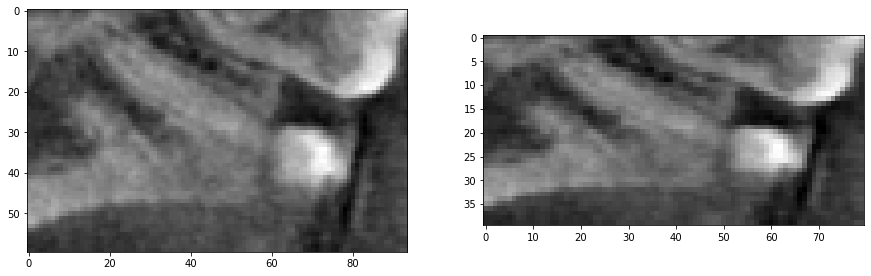

((60, 94), (40, 80))

In [9]:
# show input image slice
plt.figure(figsize=(15,15))
imgSlice = imgTarget[sliceIndex,:,:]
imgDimX, imgDimY = imgSlice.shape
imgSliceScaled = scaleImg(imgSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(imgSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgSliceScaled, cmap='gray')
plt.show()
imgSlice.shape, imgSliceScaled.shape

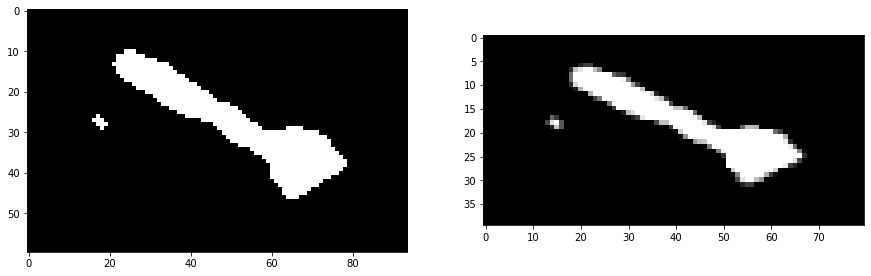

((60, 94), (40, 80))

In [10]:
# show input mask slice
plt.figure(figsize=(15,15))
maskSlice = imgMask[sliceIndex,:,:]
maskSliceScaled = scaleImg(maskSlice, IMAGE_HEIGHT, IMAGE_WIDTH)
plt.subplot(1,2,1)
plt.imshow(maskSlice, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(maskSliceScaled, cmap='gray')
plt.show()
maskSlice.shape, maskSliceScaled.shape

In [14]:
# Predict with UNET model
plt.figure(figsize=(15,15))
imageInput = imgSliceScaled[np.newaxis,:,:,np.newaxis]
maskPredict = model.predict(imageInput)[0,:,:,0]

maskPredictScaled = scaleImg(maskPredict, imgDimX, imgDimY)
plt.subplot(1,2,2)
plt.imshow(maskPredict, cmap='gray')
plt.subplot(1,2,1)
plt.imshow(maskPredictScaled, cmap='gray')
plt.show()
maskPredictScaled.shape, maskPredict.shape

ValueError: Error when checking input: expected input_17 to have 5 dimensions, but got array with shape (1, 40, 80, 1)

<Figure size 1080x1080 with 0 Axes>

## Predicting a full volume

In [466]:
def predictVolume(inImg, toBin=True):
    (xMax, yMax, zMax) = inImg.shape
    
    outImgX = np.zeros((xMax, yMax, zMax))
    outImgY = np.zeros((xMax, yMax, zMax))
    outImgZ = np.zeros((xMax, yMax, zMax))
    
    cnt = 0.0
    if SLICE_X:
        cnt += 1.0
        for i in range(xMax):
            img = scaleImg(inImg[i,:,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgX[i,:,:] = scaleImg(tmp, yMax, zMax)
    if SLICE_Y:
        cnt += 1.0
        for i in range(yMax):
            img = scaleImg(inImg[:,i,:], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
            outImgY[:,i,:] = scaleImg(tmp, xMax, zMax)
    if SLICE_Z:
        cnt += 1.0
        for i in range(zMax):
            img = scaleImg(inImg[:,:,i], IMAGE_HEIGHT, IMAGE_WIDTH)[np.newaxis,:,:,np.newaxis]
            tmp = model.predict(img)[0,:,:,0]
        
            outImgZ[:,:,i] = scaleImg(tmp, xMax, yMax)
        
         
    
    outImg = (outImgX + outImgY + outImgZ)/cnt
    
    if(toBin):
        outImg[outImg>0.5] = 1.0
        outImg[outImg<=0.5] = 0.0
    return outImg

In [467]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

predImg = predictVolume(imgTarget)
(xMax, yMax, zMax) = imgTarget.shape

from tensorflow.keras.metrics import MeanIoU,BinaryCrossentropy,Accuracy,Precision,Recall

m = MeanIoU(num_classes=2)
m.update_state(imgMask.flatten(), predImg.flatten())


m2 = BinaryCrossentropy()
m2.update_state(imgMask.flatten(), predImg.flatten())

m3 = dice_coeff(imgMask,predImg) 

m4 = Accuracy()
m4.update_state(imgMask.flatten(), predImg.flatten())

m5 = Precision()
m5.update_state(imgMask.flatten(), predImg.flatten())

m6 = Recall()
m6.update_state(imgMask.flatten(), predImg.flatten())

print("meanIOU",m.result().numpy()," DICE",m3.numpy(),"Accuracy",m4.result().numpy(),
     "Precision", m5.result().numpy(),"Recall",m6.result().numpy()," Binary cross entropy",m2.result().numpy())
    

meanIOU 0.8835378  DICE 0.8838285733314094 Accuracy 0.97736984 Precision 0.8193118 Recall 0.9593715  Binary cross entropy 0.34732813


In [468]:
maskimg = nib.Nifti1Image(predImg, np.eye(4))

nib.save(maskimg,DATA_PATH+'/output-12.nii')

my_widget = NiftiWidget(imgTargetNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=40, continuous_update=False, description='x', max=81), IntSlider(value=2…

In [469]:
my_widget = NiftiWidget(nib.dataobj_images.DataobjImage(predImg))
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=40, continuous_update=False, description='x', max=81), IntSlider(value=2…

In [470]:
my_widget = NiftiWidget(imgMaskNii)
my_widget.nifti_plotter(colormap='gray')

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=40, continuous_update=False, description='x', max=81), IntSlider(value=2…

## Convert binary image to mesh

In [471]:
oIm  = nib.load(DATA_PATH + f'/output-12.nii')

targetNii = oIm.get_fdata()

In [472]:
from skimage.measure import marching_cubes_lewiner

In [473]:
vertices,faces,_,_ = marching_cubes_lewiner(targetNii)

In [474]:
import meshplot as mp

In [475]:
mp.plot(vertices, faces, return_plot=False)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(40.5, 33.…

## Save mesh to file (.stl)

In [252]:
from stl.stl import BaseStl
from stl import mesh
import math

In [253]:
def dataToMesh(vert, faces):
    mm = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(faces):
        for j in range(3):
            mm.vectors[i][j] = -vert[f[j],:]
   
    return mm

In [254]:
mm = dataToMesh(vertices, faces)
mm.save('tooth-segmented-centered-3plane-20slices.stl')